In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sqlite3
import gc
import os

%matplotlib inline

# A) Descriptive analysis

If the wget command below does not work for any reason, then please manually download the data in zip format from: http://www.ssa.gov/oact/babynames/state/namesbystate.zip

Once downloaded, just copy it to your repository directory, and the code below.

In [2]:
if not os.path.isfile("namesbystate.zip"):
    !wget --no-check-certificate http://www.ssa.gov/oact/babynames/state/namesbystate.zip
    print("Now unzipping the file into a folder with the same name")
    !unzip -oqd namesbystate namesbystate.zip

URL transformed to HTTPS due to an HSTS policy
--2018-11-05 10:39:59--  https://www.ssa.gov/oact/babynames/state/namesbystate.zip
Resolving www.ssa.gov... 137.200.39.19, 2001:1930:e03::aaaa
Connecting to www.ssa.gov|137.200.39.19|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 21574769 (21M) [application/zip]
Saving to: ‘namesbystate.zip’

namesbystate.zip    100%[===================>]  20.58M  2.87MB/s    in 7.2s    

2018-11-05 10:40:06 (2.87 MB/s) - ‘namesbystate.zip’ saved [21574769/21574769]

Now unzipping the file into a folder with the same name


Creating a namesbystate sqlite3 database, with the intention to store all the files as a single table within the database.

In [3]:
dbname = "namesbystate.db"
if not os.path.isfile(dbname): 
    connex = sqlite3.connect(dbname)  # Opens file if exists, else creates file
    cur = connex.cursor()  # This object lets us actually send messages to our DB and receive results
    files = glob.glob("namesbystate/*TXT") # Generating a list of files within the namesbystate folder
    
    for f in files:
        # Reading each state file in to a temperory dataframe and appending it to the sqlite3 DB created above
        df_tmp = pd.read_csv(f,header=None, names=['State','Gender','Year','Name','Count']) 
        df_tmp.to_sql(name="data", con=connex, if_exists="append", index=False)
        del df_tmp 
    gc.collect() # freeing up the memory used by the dataframes
else:
    connex = sqlite3.connect(dbname)  
    cur = connex.cursor()  

### 1. Please describe the format of the data files. Can you identify any limitations or distortions of the data?


The zip file contains 52 text files, one for each of the states and the District of Columbia, and a README file describing the contents of the zip file. Each text file contains comma separated values, in the same format i.e. 2-digit state code, sex (M = male or F = female), 4-digit year of birth (starting with 1910), the 2-15 character name, and the number of occurrences of the name. 

To ensure the privacy, they exclude names with fewer than 5 occurences in a year. This generates a bias whereby individuals with unique names will be excluded from any statistical estimates based on this data.

### 2. What is the most popular name of all time? (Of either gender)

The dataset includes Names and their occurences by year. To estimate the most popular name of all time, the following SQL query is generated to return the names and the sum of the occurences, grouped by the names, ignoring the other information i.e. State, Gender, etc.

In [4]:
query = """
SELECT Name, SUM(Count) AS sum_count
FROM data
GROUP BY Name
ORDER BY SUM(Count) DESC;
"""
df = pd.read_sql_query(query, con=connex)
df.head()

,Name,sum_count
0,James,5001762
1,John,4875934
2,Robert,4743843
3,Michael,4354622
4,William,3886371


The most popular name in the United States from 1910 - 2017 is James. 

As a side note, Mary at #6 is the most popular Female name, and the only Female name in the top 10 most popular names.

In [5]:
del df

### 3. What is the most gender ambiguous name in 2013? 1945?

To compute the gender ambiguity of the names, the following logic is utilized:
- break the names database into two datasets (imported into Pandas), by year of interest and gender. 
- a join of the two DataFrames, where the names in both genders are the same.
- groupby the names and take the sum of occurrences, to generate two columns with the sum total of each name by gender.
- estimate gender neutrality by calculating the ratio of number of women with a name to the total number of individuals with a name and how far that is from 0.5. 

In [6]:
# Computing the most gender neutral name in 2013 - 
df_m = pd.read_sql_query("SELECT Name, Count FROM data WHERE Year=? AND Gender=?", con=connex, params=(2013,'M'))
df_f = pd.read_sql_query("SELECT Name, Count FROM data WHERE Year=? AND Gender=?", con=connex, params=(2013,'F'))

In [7]:
df_mf = df_m.set_index("Name").join(df_f.set_index("Name"), lsuffix='_m', rsuffix='_f').groupby("Name").sum()
df_mf["% dissimilar"] = abs(50 - 100*(df_mf["Count_f"]/(df_mf["Count_m"]+df_mf["Count_f"])))
df_mf.sort_values(by='% dissimilar').head(6)

,Count_m,Count_f,% dissimilar
Name,,,
Lake,15,15.0,0.000000
Legacy,30,30.0,0.000000
Dakotah,15,15.0,0.000000
Arlin,5,5.0,0.000000
Sonam,5,5.0,0.000000
Devyn,1900,1908.0,0.105042


In 2013, there were 5 names that were used equally for boys and girls, amongst the 5 however, Legacy was the most popular gender neutral name.  

If we were to exclude the names with fewer than 50 counts in either column, then Devyn stands out as being a very popular and yet gender neutral name in 2013.

In [8]:
# Computing the most gender neutral name in 1945 - 
df_m = pd.read_sql_query("SELECT Name, Count FROM data WHERE Year=? AND Gender=?", con=connex, params=(1945,'M'))
df_f = pd.read_sql_query("SELECT Name, Count FROM data WHERE Year=? AND Gender=?", con=connex, params=(1945,'F'))

In [9]:
df_mf = df_m.set_index("Name").join(df_f.set_index("Name"), lsuffix='_m', rsuffix='_f').groupby("Name").sum()
df_mf["% dissimilar"] = abs(50 - 100*(df_mf["Count_f"]/(df_mf["Count_m"]+df_mf["Count_f"])))
df_mf.sort_values(by='% dissimilar').head(5)

,Count_m,Count_f,% dissimilar
Name,,,
Kit,12,12.0,0.000000
Kim,588,588.0,0.000000
Loy,35,35.0,0.000000
Frankie,12627,12532.0,0.188799
Cleo,1460,1410.0,0.871080


The most gender ambiguous name in 1945 is Kit. 

The name "Frankie" at 4, is easily the most popular and gender neutral name in 1945.

In [10]:
del df_m, df_f, df_mf

### 4. Of the names represented in the data, find the name that has had the largest percentage increase in popularity since 1980. What was the largest percentage decrease since 1980?

The solution provided computes the largest increase (or decrease) in popularity between the time span specified. 

However, to show the names with the most steady gain/loss of popularity, one would need to restructure the analysis to include intermediate years. Here for each datapoint in the time-series, we would estimate a ratio (compared to the previous year), and the sum of these values would be used to rank the names.

In [11]:
query = """
SELECT Name, Year, Count
FROM data
WHERE Year >= ?
"""
df = pd.read_sql_query(query, con=connex, params=(1980,))

To calculate the percent change - we group by names, and compute the ratio of the difference of the last vs first entry divided by the first entry for each name to estimate the fraction. 

In [12]:
df_perc_change = df.set_index("Year")\
                      .groupby("Name")\
                      .apply(lambda x: 100*(x.Count.iloc[-1] - x.Count.iloc[0])/x.Count.iloc[0])\
                      .sort_values(ascending=False)
df_perc_change.head(5)

Name
Unknown     2860.0
Shimon      2480.0
Gitty       2200.0
Malka       1950.0
Yitzchok    1920.0
dtype: float64

According to the SSA database, they do not modify entries. So entries such as "Unknown" or "Baby" are kept as is. The 2860% rise in "Unknown" is interesting, but it does not represent a single name. 

Thus the name "Shimon" is name that has risen in popularity the most. Plotting the rise of babies with the name Shimon since 1980.

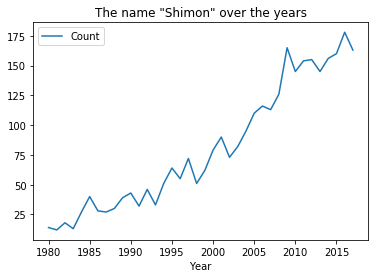

In [13]:
df[df["Name"]=="Shimon"].groupby("Year").sum().plot(title='The name "Shimon" over the years');

In [14]:
df_perc_change.tail(5)

Name
Sarah         -93.902439
Jessica       -93.965517
Latasha       -94.680851
Jennifer      -94.736842
Christopher   -95.081967
dtype: float64

Interestingly four of the five names that have dropped the most in popularity since the start of the 80s are female names. However, the name that corresponded to the largest drop in popularity is Christopher.

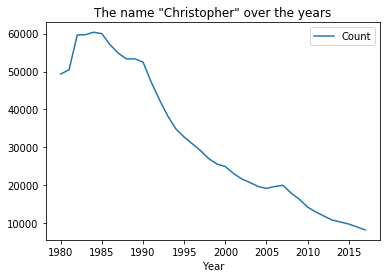

In [15]:
df[df["Name"]=="Christopher"].groupby("Year").sum().plot(title='The name "Christopher" over the years');

In [16]:
del df, df_perc_change

### 5. Can you identify names that may have had an even larger increase or decrease in popularity before 1980?

Similar to the previous question, the increase or decrease in popularity is estimated by looking for names that have shown the greatest change between 1910 and 1979.

In [ ]:
df = pd.read_sql_query("SELECT Name, Year, Count FROM data", con=connex)
df_perc_change = df[df["Year"]<1980].set_index("Year")\
                      .groupby("Name")\
                      .apply(lambda x: 100*(x.Count.iloc[-1] - x.Count.iloc[0])/x.Count.iloc[0])\
                      .sort_values(ascending=False)
df_perc_change.head(5)

Based on this analysis, it appears that no name showed a larger increase in popularity from 1910-1980, when compared to the rise seen in the name "Shimon". 

Pre-1980, the name that showed the most consistent rise in popularity is Jennifer. Interestingly enough, in our analysis in the previous question we noticed that Jennifer was the name that had the second poorest trend since 1980. The rise and fall of the name Jennifer is captured in the next plot.

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(12,6))
fig.subplots_adjust(wspace=0)
df[(df["Name"]=="Jennifer") & (df["Year"]<1980)].groupby("Year").sum().plot(ax=ax1, title='The name "Jennifer" from 1910 - 1979')
df[(df["Name"]=="Jennifer") & (df["Year"]>=1980)].groupby("Year").sum().plot(ax=ax2, title='The name "Jennifer" from 1980 - 2017');

In [ ]:
df_perc_change.tail(5)

Lillie is the name that showed the most consistent fall in popularity. This drop in popularity is in fact greater than the drop in popularity of Christopher in the previous analysis.

In [ ]:
df[(df["Name"]=="Lillie") & (df["Year"]<1980)].groupby("Year").sum().plot(title='The name "Lillie" from 1910 - 1979');

There are two important points to consider from the figure above,
- while the name Lillie showed a larger decrease in popularity compared to Christopher. In absolute terms, even at its most popular, the name Lillie only went to ~3000 babies per year. While the name Christopher is at its lowest currently, but there are still ~10000 babies with that name born in 2017. 
- it is also interesting to note is that the name Lillie was actually on a rising trend till 1920 before it dropped. So it's actually percentage decrease is better captured by the difference of the max and min counts, rather than the first and last. 

To examine whether there are names that have had large changes in popularity, we used the ratio of the difference of the max - min by the min count and present the results below (limited the results to names that have turned up at least 30 times over the years).

In [ ]:
df_perc_change_minmax = df[df["Year"]<1980].set_index("Year")\
                      .groupby("Name")\
                      .apply(lambda x: 100*(x.Count.max() - x.Count.min())/x.Count.min() if len(x.Count) > 30 else np.nan)\
                      .dropna()\
                      .sort_values(ascending=False)
df_perc_change_minmax.head()

There are the names that have shown significantly larger variation over the years. The name Robert has seen a whopping 200300% change in popularity from 1910 to 1980. And as can be seen in the plot below, its popularity peaked in early 1940s and has declined ever since.

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(12,6))
fig.subplots_adjust(wspace=0)
df[(df["Name"]=="Robert") & (df["Year"]<1980)].groupby("Year").sum().plot(ax=ax1, title='The name "Robert" from 1910 - 1979')
df[(df["Name"]=="Robert") & (df["Year"]>=1980)].groupby("Year").sum().plot(ax=ax2, title='The name "Robert" from 1980 - 2017');

Another surprising inclusion in the list of largest change, is the name "Mary". Note that Mary has been the most popular female name in the US over the past 117 years. However, when one plots the trend line for the name it is interesting to note how the popularity has varied over the last 12 decades.

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(12,6))
fig.subplots_adjust(wspace=0)
df[(df["Name"]=="Mary") & (df["Year"]<1980)].groupby("Year").sum().plot(ax=ax1, title='The name "Mary" from 1910 - 1979')
df[(df["Name"]=="Mary") & (df["Year"]>=1980)].groupby("Year").sum().plot(ax=ax2, title='The name "Mary" from 1980 - 2017');

Mary might be the most popular female name by total numbers, however, the name has seen a dramatic drop in popularity since approximately the 70s and is far from being a popular name for babies today.

Based on this plot, we can probably estimate that the average age of a person with the name Mary or Robert in the US is probably 50 - 60 years. To accurately compute the average age, we would need to include the average life expectancy for individuals. 

In [ ]:
del df, df_perc_change, df_perc_change_minmax
gc.collect();

# B) Onwards to insight

## Missing names

Right at the onset of the analysis it was noted that for protection of the privacy of individuals, names that occurred fewer than 5 times in a state would be excluded. 

It was noted that this would result in a bias whereby the names of babies born would not reflect the actual numbers of babies in each state. This problem is further exacerbated by the fact that the dataset provided is collatted by state (rather than national), which will have the tendency to increase the likelihood of excluding unique names.

It is valuable to understand the limitations of the SSA names dataset, and to place limits on how accurately it represents the populace. To investigate the issue of a bias, the following national birth and birth rate data datasets were included in the analysis: 
- The first is Infoplease (https://www.infoplease.com/), who describe themselves as an online encyclopedia. The website contains birth and birth rate information from 1910 to 2005. Between 1910 and 1950, the data points are once every 5 years, and from 1950 onwards they are annual. The data are sourced from the United States Department of Health and Human Services.
- The second data source is the WONDER Online Database (http://wonder.cdc.gov/natality-current.html ), administered by the United States Department of Health and Human Services (US DHHS), and Centers for Disease Control and Prevention Center for Disease Control. This dataset covers births in the US between 1995 and 2017. 

In [ ]:
# Extracting data from the SSA database
df = pd.read_sql_query("SELECT Name, Year, Count FROM data", con=connex)

To gather the data from the Infoplease website, we will use the Python requests library in combination with the BautifulSoup library. The parsed table, is converted to a Pandas DataFrame. 

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
url = "https://www.infoplease.com/us/births/live-births-and-birth-rates-year"
r = requests.get(url)
soup = BeautifulSoup(r.text, "lxml")

In [ ]:
table = soup.table
rows = []
for tr in table:
    if tr.sup:
        tr.sup.decompose()
    td = tr.find_all('td')
    rows.append([i.text for i in td])
df_infopls = pd.DataFrame(rows[1:], columns=["Year","Births","Birth Rate"])

In [ ]:
df_infopls["Year"] = df_infopls["Year"].astype("int")
df_infopls["Births"] = df_infopls["Births"].str.replace(",","").astype("int")
df_infopls["Birth Rate"] = df_infopls["Birth Rate"].astype("float")

Including data taken from the CDC WONDER (Wide-ranging OnLine Data for Epidemiologic Research) data.

The procedure to download this data is as follows: 
- navigate to WONDER website: https://wonder.cdc.gov/natality.html, to download the data from 1995 to 2017 from three separate web forms.
- there does not appear to be an API to download the data. So the data was manually downloaded data and reformatted into a CSV file: NationalBirths.csv. 
    - the CSV file has the information from all three web forms in a single page.
    - unfortunately, due to the manual formatting, expanding the analysis to include State information or other relevant pieces of information that are present through WONDER is quite tedious. Future work should either find a way to request data directly, or write a parser to read in the file format of WONDER database exported data. 

In [ ]:
cdc_df_1995_2017 = pd.read_csv("NationalBirths.csv", index_col="Year", skipfooter=8, engine="python")
cdc_df_1995_2017["Total"] = cdc_df_1995_2017['M_Births'] + cdc_df_1995_2017['F_Births']

In [ ]:
df_all3 = df.groupby("Year").sum()
df_all3 = df_all3.join(df_infopls.set_index("Year")).join(cdc_df_1995_2017)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,10), sharex=True, gridspec_kw={'height_ratios':[2, 1]})
fig.subplots_adjust(hspace=0)
df_all3.plot(y="Count", ax=ax1, label='SSA Names Count')
df_all3["Births"].dropna().plot(ax=ax1, marker="*", label='Infoplease Count')
df_all3["Total"].dropna().plot(ax=ax1, marker="*", label='DHHS and CDC Count')
ax1.set_ylabel("# babies born", fontsize=15)
ax1.legend(fontsize=12)
(df_all3["Births"] - df_all3["Count"]).dropna().plot(ax=ax2, marker="*", color='k')
(df_all3["Total"] - df_all3["Count"]).dropna().plot(ax=ax2, marker="*", color='k')
ax2.set_ylabel("Residual", fontsize=15)
ax2.set_xlabel("Year", fontsize=15)
ax1.set_title("Total births by year in the US", fontsize=17);

Plotted in the top panel of the figure above is the total number of births in the US as recorded by the SSA names database (in blue), and the DHHS (in orange and green). The bottom panel in
- The values pre-1959 for the SSA vs DHHS plot are quite discrepant, and this is likely due to the DHHS adjusting the birth numbers for unregistered births, for reasons not clarified.
- If we assume that the two databases are fairly in synch post 1960, then the national trend over the past 50 years is that Americans are increasingly choosing more unique names for their children. 
- This trend appears to be stabilizing over the past ~10 years.

Next we expand this analysis to examine whether this trend holds for both genders. 

In [ ]:
df = pd.read_sql_query("SELECT Name, Gender, Year, Count FROM data WHERE Year >= ?", con=connex, params=(1995,))

In [ ]:
df_group = df.groupby(["Year","Gender"]).sum().unstack()

In [ ]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10), sharex=True, gridspec_kw={'height_ratios':[4, 2]})
fig.subplots_adjust(hspace=0.05)

df_group["Count","F"].plot(ax=ax1, label='SSA Names Count'); cdc_df_1995_2017["F_Births"].plot(ax=ax1, label='DHHS and CDC Count')
df_group["Count","M"].plot(ax=ax2, label='SSA Names Count'); cdc_df_1995_2017["M_Births"].plot(ax=ax2, label='DHHS and CDC Count')
ax1.set_ylim(1.2E6,2.5E6); ax2.set_ylim(1.2E6,2.5E6)
ax1.legend(); ax2.legend()
ax1.set_ylabel("# of baby girls", fontsize=15); ax2.set_ylabel("# of baby boys", fontsize=15)
ax1.set_title("Girls born in the US", fontsize=17); ax1.set_title("Boys born in the US", fontsize=17)

(cdc_df_1995_2017["F_Births"] - df_group["Count","F"]).plot(ax=ax3, color='k')
(cdc_df_1995_2017["M_Births"] - df_group["Count","M"]).plot(ax=ax4, color='k')
ax3.set_ylim(2E5,7.5E5); ax4.set_ylim(2E5,7.5E5);
ax3.set_ylabel("Residual", fontsize=15); ax4.set_ylabel("Residual", fontsize=15)
ax3.set_xlabel("Year", fontsize=15); ax4.set_xlabel("Year", fontsize=15);

Plotted above are the birth statistics for girls (left) and boys (right), comparing the actual number of births (orange line) and the registered names with greater than 5 occurrences (blue line). The residuals panel shows the rate of change of the unique names as a function of time. 

- Both genders show a similar rising trend, that is a rising discrepancy between actual births and names, till ~2006-2008, after which it has stabilized over the past decade. 
- According to both, the SSA names database and the WONDER database, there are more boys born then girls per year, over the entire duration.
- However, the discrepancy between the names and births for the girls is a lot larger than that seen for boys, 1.42x greater to be precise. 

Taking this thought exercise a little further. If the discrepancy is attributed purely to the fact that at any name with fewer than 5 occurrences in a state would be kept out of the list.  
- Then this would suggest that in 2017 there were 486994 female names and 378149 male names excluded. 
- Or ~17000 names across the 51 regions (50 states + DC). These could be unique names or ones that total to fewer than 4 occurrences per state.
- Furthermore, when we compare this to actual births by gender from WONDER (1882615 girls and 1972885 boy in 2017), the discrepancy represents ~25% girl names and 20% boys names missing. 

It was originally speculated that there "might" be a discrepancy between the actual births and the names in SSA database. Clearly, the analysis above has confirmed the existence of a discrepancy. However, to attribute nearly a million baby names missing due to uniqueness of name, seems highly improbable. 

To look for possible explanation for the discrepancy, let us consider the source for each of the datasets. 
- The SSA dataset lists the names of babies from Social Security Card Applications (https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-data-by-state-and-district-of-). 
- The WONDER dataset has counts and rates of births occurring within the United States to U.S. residents and non-residents. (https://wonder.cdc.gov/wonder/help/Natality.html)

Not including names with occurrences less than 5 is definitely a contributor. Here are some of the other plausible causes for missing baby names: 
- if the rate of parents filing SSA for infants has been dropping with time.
- or, if it could be related to the rise of immigrants in the US from Asian countries where systems like Social Security are not as common and thus not immediately perceived as useful. 
- or, another possible explanation is if there has been a significant increase in undocumented immigrants over the past 20 years (compared to the period from 1960-1980). These children might remain unregistered, though it would require further exploration to understand why they would show up in the DHHS & CDC dataset. 

The demographics of the top 10 countries sending immigrants to the US is shown in this Wikipedia article:  https://en.wikipedia.org/wiki/Immigration_to_the_United_States#Demographics.

Whatever the reason, this discrepancy would appear to significantly bias the SSA names dataset. 

In [ ]:
del df, df_all3, df_group, df_infopls

## Name variants:

The SSA dataset keeps different spellings of the same name as distinct, see point 3 here: https://www.ssa.gov/oact/babynames/background.html. So the following names - Caitlin, Caitlyn, Kaitlin, Kaitlyn, Kaitlynn, Katelyn, and Katelynn would be considered as different names and thus be ranked separately. 

Depending on the analysis being requested, it might be useful to consider these names as arising from a common root. For example, individually from the names mentioned above, "Kaitlyn" is the most popular variant - ranking 421st amongst the most popular names (for either gender). However, the combined statistics for these names would make the name the 104th most popular name of all time. 

To try to resolved this issue, there is a Python package called Fuzzywuzzy, which calculates the Levenshtein distance between two strings. Examples of this in action are shown below.

In [ ]:
from fuzzywuzzy import fuzz

In [ ]:
fuzz.ratio("Caitlin", "Caitlinn"), fuzz.partial_ratio("Katelyn", "Katelynn")

In [ ]:
fuzz.ratio("Caitlin", "Katelyn"), fuzz.partial_ratio("Kaitlin", "Katelynn")

One method to combine names together is to generate a matrix of comparative values, using the logic above, where we compare all the names against each other. A cut-off value needs to be determined depending on how inclusive or exclusive one wants to be, and then retain that subset of the names to combine the statistics and generate a new names dataset. This new dataset could then be examined in exactly the same manner as earlier.

This tool could also be utilized when attempting name/identity matching where there are possibilities of errors in spelling or alternate spellings, etc. 

In [ ]:
cur.close()
del cur
connex.close()